IMPORT LIBRARIES

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


LOAD DATASETS

In [27]:
# Load datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Convert date columns to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])


In [28]:
# Merge transactions with customers
customer_transactions = pd.merge(transactions, customers, on='CustomerID', how='inner')
# Merge products
data = pd.merge(customer_transactions, products, on='ProductID', how='inner')


In [30]:
data.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics,300.68


FEATURE SELECTION

In [32]:
# Aggregated features at customer level
customer_data = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',       # Total spending
    'TransactionID': 'count', # Number of transactions
    'Price_x': 'mean',          # Average transaction price
    'Quantity': 'sum'         # Total quantity purchased
}).rename(columns={
    'TotalValue': 'TotalSpending',
    'TransactionID': 'TransactionCount',
    'Price': 'AvgTransactionPrice',
    'Quantity': 'TotalQuantity'
})

# Add region as a categorical feature
customer_data = customer_data.merge(customers[['CustomerID', 'Region']], on='CustomerID', how='left')

# One-hot encode the 'Region'
encoder = OneHotEncoder(sparse_output=False)
region_encoded = encoder.fit_transform(customer_data[['Region']])
region_encoded_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(['Region']))
customer_data = pd.concat([customer_data, region_encoded_df], axis=1).drop('Region', axis=1)


In [33]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data.drop('CustomerID', axis=1))


CLUSTERING

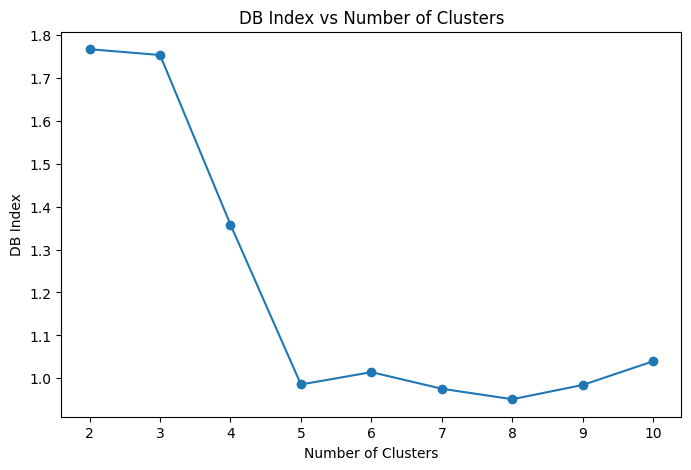

Optimal number of clusters: 8, DB Index: 0.9513267333851491


In [34]:
# Determine optimal clusters using Davies-Bouldin Index
db_scores = []
cluster_range = range(2, 11)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(scaled_data)
    db_index = davies_bouldin_score(scaled_data, clusters)
    db_scores.append(db_index)

# Plot DB Index for different cluster numbers
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, db_scores, marker='o')
plt.title('DB Index vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.show()

# Choose the optimal number of clusters (lowest DB Index)
optimal_k = cluster_range[np.argmin(db_scores)]
print(f"Optimal number of clusters: {optimal_k}, DB Index: {min(db_scores)}")


In [35]:
# Train KMeans with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_data)

# Add cluster labels
cluster_centers = kmeans.cluster_centers_


PCA

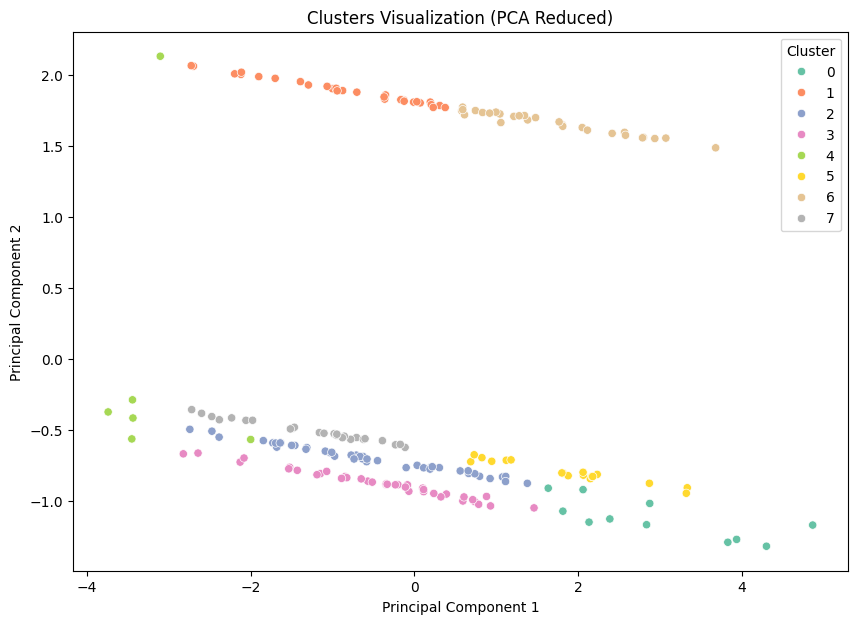

In [36]:
# PCA for 2D visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=customer_data['Cluster'], palette='Set2')
plt.title('Clusters Visualization (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


ADDING RECENCY, FREQUENCY, AVG BASKET SIZE

In [37]:
# Add Recency (days since last transaction)
customer_data['Recency'] = (data['TransactionDate'].max() - data.groupby('CustomerID')['TransactionDate'].max()).dt.days

# Add Frequency (average transactions per month)
customer_data['Frequency'] = data.groupby('CustomerID')['TransactionID'].count() / (
    (data['TransactionDate'].max() - data['TransactionDate'].min()).days / 30
)

# Add Average Basket Size
customer_data['AvgBasketSize'] = customer_data['TotalSpending'] / customer_data['TransactionCount']


NOISE REMOVAL AND DBSCAN

In [39]:
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import DBSCAN

# Assuming `scaled_data` is your input data for clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(scaled_data)

# Exclude noise points from both data and cluster labels
valid_data = scaled_data[clusters != -1]
valid_clusters = clusters[clusters != -1]

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(valid_data, valid_clusters)
print(f"DBSCAN DB Index: {db_index}")


DBSCAN DB Index: 0.15727583208696366


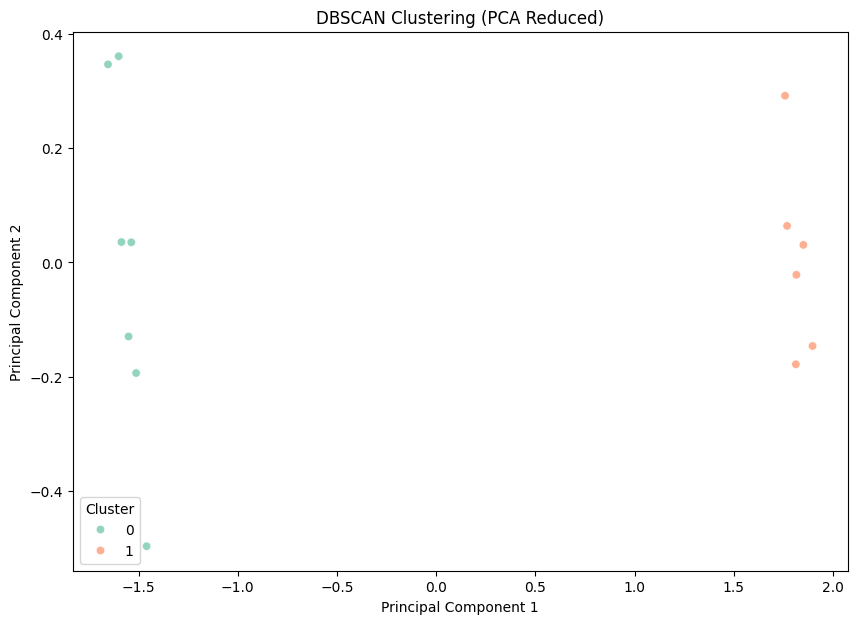

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Reduce data to 2 dimensions using PCA for visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(valid_data)

# Plotting clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=pca_data[:, 0], y=pca_data[:, 1],
    hue=valid_clusters, palette='Set2', legend='full', alpha=0.7
)
plt.title('DBSCAN Clustering (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', loc='best')
plt.show()


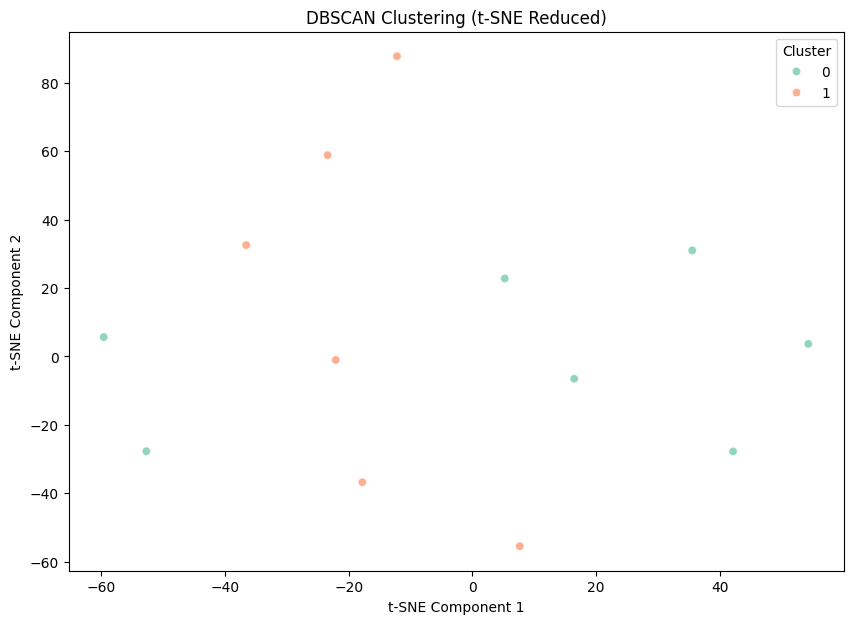

In [46]:
tsne = TSNE(n_components=2, random_state=42, perplexity=10, n_iter=300)
tsne_data = tsne.fit_transform(valid_data)

# Plotting t-SNE clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=tsne_data[:, 0], y=tsne_data[:, 1],
    hue=valid_clusters, palette='Set2', legend='full', alpha=0.7
)
plt.title('DBSCAN Clustering (t-SNE Reduced)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster', loc='best')
plt.show()
